# Forecasting the Top 10 of Spotify's Viral 50 Italy Chart with Moirai2
## Workshop on Time Series Forecasting with Foundation Models

**Goal**: Use Salesforce's Moirai2 foundation model to predict which songs will be in the **Top 10** of Italy's Viral 50 chart tomorrow.

**Why Moirai2?**
- Pre-trained foundation model from Salesforce
- Universal forecasting model (multi-scale support)
- Zero-shot forecasting capability
- Trained on diverse time series data
- State of Art in time series forecasting
    - Paper: [Moirai 2.0: When Less Is More for Time Series Forecasting](https://www.arxiv.org/abs/2511.11698) (12 Nov 2025)

---
## Section 1: Setup & Quick Introduction

First, let's import our libraries and load the dataset.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Moirai2
from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module
from gluonts.dataset.common import ListDataset

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load the Spotify Viral 50 Italy dataset
# This dataset contains daily rankings (1-50) for viral songs in Italy
# https://www.kaggle.com/datasets/dhruvildave/spotify-charts
df = pd.read_csv('data/viral50_italy.csv')

# Convert date column to datetime format
# This will help us enabling time-based operations on the data and sorting
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique songs: {df['title'].nunique():,}")
print(f"Unique artists: {df['artist'].nunique():,}")
print("\nFirst few rows:")
df.head(10)

Dataset shape: 90,927 rows × 7 columns
Date range: 2017-01-01 00:00:00 to 2021-12-31 00:00:00
Unique songs: 6,538
Unique artists: 4,002

First few rows:


,title,rank,date,artist,region,chart,trend
0,Caught In The Middle,1,2017-08-01,Anastacia,Italy,viral50,SAME_POSITION
1,Sei la mia notifica preferita,2,2017-08-01,Francesco Sole,Italy,viral50,SAME_POSITION
2,Back to You (feat. Bebe Rexha & Digital Farm A...,3,2017-08-01,Louis Tomlinson,Italy,viral50,MOVE_UP
3,Barceloneta,4,2017-08-01,"Carl Brave x Franco126, Coez",Italy,viral50,MOVE_DOWN
4,Le focaccine dell'Esselunga,5,2017-08-01,OEL,Italy,viral50,MOVE_DOWN
5,Not Dead Yet,6,2017-08-01,"Falling Apart, Jeffrey James",Italy,viral50,MOVE_UP
6,We are the wild ones,7,2017-08-01,Cinemaboy,Italy,viral50,MOVE_DOWN
7,Gotta Get A Grip,8,2017-08-01,Mick Jagger,Italy,viral50,MOVE_UP
8,Riccione,9,2017-08-01,Thegiornalisti,Italy,viral50,SAME_POSITION
9,The Flow Is Slava,10,2017-08-01,"Slava, Finest Music",Italy,viral50,MOVE_UP


In [3]:
# Quick data quality check
print("=== DATA QUALITY CHECK ===")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nRank range: {df['rank'].min()} to {df['rank'].max()}") # 51 ranking indicates out-of-chart position
print(f"\nTrend distribution:\n{df['trend'].value_counts()}")

# Descriptive statistics
print("\nDescriptive statistics:")
df.describe()

=== DATA QUALITY CHECK ===
Missing values:
title     0
rank      0
date      0
artist    0
region    0
chart     0
trend     0
dtype: int64

Duplicate rows: 0

Rank range: 1 to 51

Trend distribution:
trend
MOVE_DOWN        35650
MOVE_UP          29122
SAME_POSITION    16803
NEW_ENTRY         9352
Name: count, dtype: int64

Descriptive statistics:


,rank,date
count,90927.000000,90927
mean,25.507770,2019-07-03 05:39:47.766009856
min,1.000000,2017-01-01 00:00:00
25%,13.000000,2018-04-02 00:00:00
50%,26.000000,2019-07-04 00:00:00
75%,38.000000,2020-10-02 12:00:00
max,51.000000,2021-12-31 00:00:00
std,14.437062,NaN


---
## Section 2: Data Preparation & Visualization

**Key Challenge**: Songs enter and exit the chart frequently. We need to create continuous time series for each song.

**Solution**: 
- For days when a song is NOT in the chart, assign rank = 51 (one below the chart)
- This allows Moirai2 to learn when songs enter/exit the chart

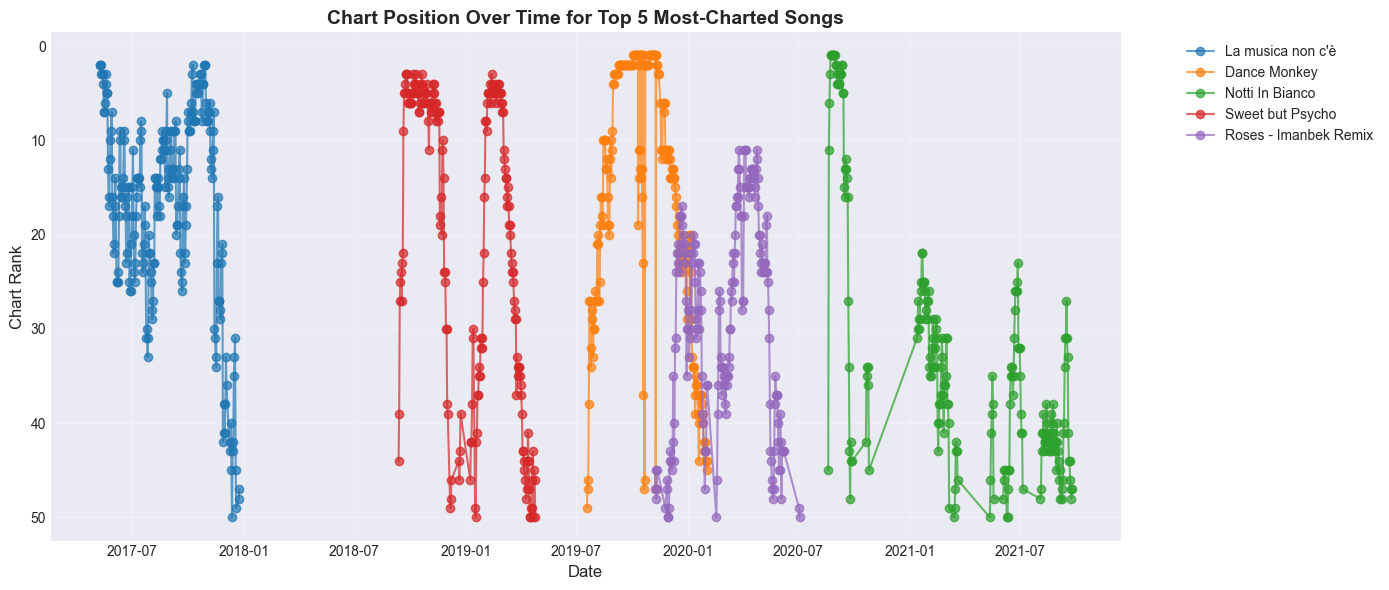

Key Observations:
- Songs have varying lifespans in the chart
- Rankings fluctuate day-to-day (volatility)
- Some songs peak quickly, others climb gradually


In [4]:
# Let's visualize how a few popular songs perform over time
# This helps us understand the temporal patterns Moirai2 will learn

# Select 5 songs with the most chart appearances
top_songs = df.groupby('title').size().nlargest(5).index

plt.figure(figsize=(14, 6))
for song in top_songs:
    song_data = df[df['title'] == song].sort_values('date')
    plt.plot(song_data['date'], song_data['rank'], marker='o', label=song[:30], alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Chart Rank', fontsize=12)
plt.title('Chart Position Over Time for Top 5 Most-Charted Songs', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Invert so rank 1 is at the top
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key Observations:")
print("- Songs have varying lifespans in the chart")
print("- Rankings fluctuate day-to-day (volatility)")
print("- Some songs peak quickly, others climb gradually")

In [5]:
# Create a unique identifier for each song
# Some songs have the same title but different artists
df['song_id'] = df['artist'] + ' - ' + df['title']

In [6]:
# Define our train/test split
# CRITICAL: In time series, we CANNOT randomly shuffle data!
# Why? Because we're predicting the future based on the past.

# We'll use the last 14 days as our test period for evaluation
# This gives us multiple test points to evaluate model stability
test_days = 14
all_dates = sorted(df['date'].unique())
test_start_date = all_dates[-test_days]
test_end_date = all_dates[-1]

print(f"Training period: {df['date'].min()} to {test_start_date - timedelta(days=1)}")
print(f"Test period: {test_start_date} to {test_end_date} ({test_days} days)")
print(f"\nWe'll make predictions for each day in the test period using only past data.")

Training period: 2017-01-01 00:00:00 to 2021-12-17 00:00:00
Test period: 2021-12-18 00:00:00 to 2021-12-31 00:00:00 (14 days)

We'll make predictions for each day in the test period using only past data.


---
## Section 3: Moirai2 Forecasting

**How Moirai2 Works**:
1. Uses GluonTS format for data input
2. Takes a historical time series as input (e.g., ranks for the last N days)
3. Predicts the next value(s) in the series
4. Returns probabilistic forecasts (samples or mean)

**Our Strategy**:
- For each song, use its historical ranks to predict tomorrow's rank
- Select the 10 songs with the lowest predicted ranks as our "Top 10"

In [7]:
# Load the Moirai2 model
# This is a pre-trained model from Salesforce

print("Loading Moirai2 model...")
model = Moirai2Forecast(
    module=Moirai2Module.from_pretrained(
        "Salesforce/moirai-2.0-R-small",
    ),
    prediction_length=1,
    context_length=180,  # Use last 180 days of history (matching Chronos2 setup)
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Create predictor for batch inference
predictor = model.create_predictor(batch_size=32)
print("✓ Model loaded successfully!")

Loading Moirai2 model...
✓ Model loaded successfully!


In [8]:
# Strategy: For each test day, we'll focus on recently active songs

recent_window = 30  # Look at songs active in the last 30 days

print(f"For each test day, we'll predict for songs active in the last {recent_window} days")
print("This is a practical optimization for real-world forecasting.")

For each test day, we'll predict for songs active in the last 30 days
This is a practical optimization for real-world forecasting.


In [9]:
# Helper function to convert our data to GluonTS format
def create_gluonts_dataset(song_histories, song_ids, start_date, freq='D'):
    """
    Convert song histories to GluonTS format
    
    Args:
        song_histories: dict mapping song_id -> numpy array of historical ranks
        song_ids: list of song_ids to include
        start_date: pandas Timestamp for the start of the time series
        freq: frequency string (D for daily)
    
    Returns:
        GluonTS ListDataset
    """
    dataset_entries = []
    for song_id in song_ids:
        if song_id in song_histories:
            dataset_entries.append({
                'target': song_histories[song_id],
                'start': start_date,
                'item_id': song_id
            })
    
    return ListDataset(dataset_entries, freq=freq)

print("✓ Helper function defined")

✓ Helper function defined


In [10]:
# ROLLING PREDICTIONS: Predict each test day using only past data
# This is the proper way to evaluate time series models!

# Storage for all predictions
all_predictions = []  # List of dicts with prediction results
all_daily_predictions = {}  # Dict mapping date -> {song_id: predicted_rank}

# Parameters
context_length = 180  # Use last 180 days of history (matching Chronos2)
prediction_horizon = 1  # Predict 1 day ahead

# Get test dates (we'll predict days starting from test_start_date)
test_dates = sorted(df[df['date'] >= test_start_date]['date'].unique())

print(f"Starting rolling predictions for {len(test_dates)} test days...")

for day_idx, test_date in enumerate(test_dates):
    print(f"[{day_idx+1}/{len(test_dates)}] Predicting for {test_date.strftime('%Y-%m-%d')}...")
    
    # Get training data up to (but not including) test_date
    train_end_date = test_date - timedelta(days=1)
    train_df = df[df['date'] <= train_end_date].copy()
    
    # Create time series for this training set
    time_series_df = train_df.pivot_table(
        index='song_id',
        columns='date',
        values='rank',
        fill_value=51
    )
    
    # Get recently active songs
    recent_dates = train_df['date'].nlargest(recent_window).unique() # Last 'recent_window' dates
    recent_songs = train_df[train_df['date'].isin(recent_dates)]['song_id'].unique() # Last 'recent_window' days' songs
    
    # Prepare data for GluonTS format
    song_histories = {}
    valid_songs = []
    
    for song_id in recent_songs:
        if song_id in time_series_df.index:
            # Get the song's historical ranks
            song_history = time_series_df.loc[song_id].values
            
            # Take the last 'context_length' days
            context = song_history[-context_length:]
            
            song_histories[song_id] = context.astype(np.float32)
            valid_songs.append(song_id)
    
    # Create GluonTS dataset
    # Start date is context_length days before the test_date
    start_date = test_date - timedelta(days=context_length)
    gluonts_data = create_gluonts_dataset(song_histories, valid_songs, start_date)
    
    # Make batch predictions
    forecasts = predictor.predict(gluonts_data)
    
    # Extract predictions
    daily_predictions = {}
    for song_id, forecast in zip(valid_songs, forecasts):
        # Get the median prediction (Moirai2 returns median, not mean)
        # Using median avoids warning messages from GluonTS
        predicted_rank = forecast.median[0]  # First (and only) time step
        predicted_rank = np.clip(predicted_rank, 1, 51)
        daily_predictions[song_id] = predicted_rank
    
    # Get actual top 10 for this test date
    actual_test_data = df[df['date'] == test_date].copy()
    actual_top10_songs = set(actual_test_data.nsmallest(10, 'rank')['song_id'])
    actual_ranks = actual_test_data.set_index('song_id')['rank'].to_dict()
    
    # Get predicted top 10
    predicted_top10_songs = set(sorted(daily_predictions.items(), key=lambda x: x[1])[:10])
    predicted_top10_song_ids = {s[0] for s in predicted_top10_songs}
    
    # Calculate metrics for this day
    correct_in_top10 = len(predicted_top10_song_ids & actual_top10_songs)
    precision = correct_in_top10 / 10
    recall = correct_in_top10 / 10
    
    # Calculate RMSE for common songs
    common_songs = [s for s in daily_predictions.keys() if s in actual_ranks]
    if len(common_songs) > 0:
        y_true = [actual_ranks[s] for s in common_songs]
        y_pred = [daily_predictions[s] for s in common_songs]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
    else:
        rmse = mae = np.nan
    
    # Store results
    all_predictions.append({
        'date': test_date,
        'precision@10': precision,
        'recall@10': recall,
        'correct_top10': correct_in_top10,
        'rmse': rmse,
        'mae': mae,
        'n_songs_evaluated': len(common_songs)
    })
    
    all_daily_predictions[test_date] = daily_predictions
    
    print(f"    ✓ Precision@10: {precision:.1%}, RMSE: {rmse:.2f}, Songs: {len(common_songs)}")

Starting rolling predictions for 14 test days...
[1/14] Predicting for 2021-12-18...
    ✓ Precision@10: 90.0%, RMSE: 2.50, Songs: 48
[2/14] Predicting for 2021-12-19...
    ✓ Precision@10: 100.0%, RMSE: 2.82, Songs: 47
[3/14] Predicting for 2021-12-20...
    ✓ Precision@10: 80.0%, RMSE: 7.01, Songs: 41
[4/14] Predicting for 2021-12-21...
    ✓ Precision@10: 80.0%, RMSE: 4.93, Songs: 45
[5/14] Predicting for 2021-12-22...
    ✓ Precision@10: 80.0%, RMSE: 4.55, Songs: 50
[6/14] Predicting for 2021-12-23...
    ✓ Precision@10: 100.0%, RMSE: 3.03, Songs: 48
[7/14] Predicting for 2021-12-24...
    ✓ Precision@10: 80.0%, RMSE: 4.97, Songs: 47
[8/14] Predicting for 2021-12-25...
    ✓ Precision@10: 90.0%, RMSE: 3.88, Songs: 45
[9/14] Predicting for 2021-12-26...
    ✓ Precision@10: 100.0%, RMSE: 5.18, Songs: 48
[10/14] Predicting for 2021-12-27...
    ✓ Precision@10: 60.0%, RMSE: 11.81, Songs: 32
[11/14] Predicting for 2021-12-28...
    ✓ Precision@10: 70.0%, RMSE: 7.28, Songs: 46
[12/14] Pr

In [11]:
# Convert to DataFrame for analysis
results_df = pd.DataFrame(all_predictions)

print(f"\n✓ Completed predictions for {len(test_dates)} days!")
print("\n" + "="*60)
print("AGGREGATE RESULTS ACROSS ALL TEST DAYS")
print("="*60)
print(f"Average Precision@10: {results_df['precision@10'].mean():.2%} ± {results_df['precision@10'].std():.2%}")
print(f"Average Recall@10:    {results_df['recall@10'].mean():.2%} ± {results_df['recall@10'].std():.2%}")
print(f"Average RMSE:         {results_df['rmse'].mean():.2f} ± {results_df['rmse'].std():.2f}")
print(f"Average MAE:          {results_df['mae'].mean():.2f} ± {results_df['mae'].std():.2f}")
print(f"Average correct:      {results_df['correct_top10'].mean():.1f}/10 songs")
print("="*60)


✓ Completed predictions for 14 days!

AGGREGATE RESULTS ACROSS ALL TEST DAYS
Average Precision@10: 83.57% ± 12.16%
Average Recall@10:    83.57% ± 12.16%
Average RMSE:         5.19 ± 2.36
Average MAE:          3.65 ± 1.91
Average correct:      8.4/10 songs


In [12]:
# Display detailed results for all test days
print("=== DAILY PREDICTION RESULTS ===\n")
print(results_df.to_string(index=False))

# Show example: Predicted top 10 for the last test day
last_test_date = test_dates[-1]
last_day_predictions = all_daily_predictions[last_test_date]
predicted_top10_last_day = sorted(last_day_predictions.items(), key=lambda x: x[1])[:10]

print(f"\n\n=== EXAMPLE: PREDICTED TOP 10 FOR {last_test_date.strftime('%Y-%m-%d')} ===")
for i, (song_id, pred_rank) in enumerate(predicted_top10_last_day, 1):
    print(f"{i:2d}. {song_id[:60]:60s} | Pred: {pred_rank:5.1f}")

=== DAILY PREDICTION RESULTS ===

      date  precision@10  recall@10  correct_top10      rmse      mae  n_songs_evaluated
2021-12-18           0.9        0.9              9  2.501023 1.859069                 48
2021-12-19           1.0        1.0             10  2.815290 1.946162                 47
2021-12-20           0.8        0.8              8  7.008245 4.824406                 41
2021-12-21           0.8        0.8              8  4.927325 3.941717                 45
2021-12-22           0.8        0.8              8  4.545583 2.835870                 50
2021-12-23           1.0        1.0             10  3.031927 2.302891                 48
2021-12-24           0.8        0.8              8  4.974927 2.765649                 47
2021-12-25           0.9        0.9              9  3.875319 2.777575                 45
2021-12-26           1.0        1.0             10  5.175145 3.072499                 48
2021-12-27           0.6        0.6              6 11.814500 9.333203       

---
## Section 4: Evaluation 

**Question**: How do we know if our predictions are good?

**We'll use 3 types of metrics**:
1. **RMSE** (Root Mean Squared Error): How far off are our rank predictions?
2. **Precision@10**: Of our predicted Top 10, how many were actually in the Top 10?
3. **Hit Rate**: Did we get at least 1 song correct?

Let's compare our predictions to the actual Top 10 on the test date.

In [13]:
# For detailed analysis, let's look at the last test day
# (You can change this to analyze any specific day)

analysis_date = test_dates[-1]  # Last day
actual_test_data = df[df['date'] == analysis_date].copy()
actual_top10 = actual_test_data.nsmallest(10, 'rank')[['song_id', 'rank', 'title', 'artist']]
actual_top10 = actual_top10.rename(columns={'rank': 'actual_rank'})
actual_top10['actual_position'] = range(1, 11)

print(f"=== ACTUAL TOP 10 FOR {analysis_date.strftime('%Y-%m-%d')} ===\n")
print(actual_top10[['actual_position', 'song_id', 'actual_rank']].to_string(index=False))

=== ACTUAL TOP 10 FOR 2021-12-31 ===

 actual_position                                                                                                                                                             song_id  actual_rank
               1                                                                                                                                                  GoldSkull - TO THE            1
               2                                                                                                             Edison Lighthouse - Love Grows (Where My Rosemary Goes)            2
               3                                                                                                                                            JV.JARVIS - น้ำแดงน้ำส้ม            3
               4                     Carolina Gaitán - La Gaita, Mauro Castillo, Adassa, Rhenzy Feliz, Diane Guerrero, Stephanie Beatriz, Encanto - Cast - We Don't Talk About Bruno      

In [14]:
# Get predictions for the analysis date
analysis_predictions = all_daily_predictions[analysis_date]
predicted_top10_analysis = sorted(analysis_predictions.items(), key=lambda x: x[1])[:10]
predicted_df = pd.DataFrame(predicted_top10_analysis, columns=['song_id', 'predicted_rank'])
predicted_df['index'] = range(1, 11)

# Merge with FULL test data to get actual ranks for all songs
actual_test_data_full = df[df['date'] == analysis_date].copy()
actual_ranks_all = actual_test_data_full[['song_id', 'rank', 'title', 'artist']].rename(columns={'rank': 'actual_rank'})

comparison_df = predicted_df.merge(
    actual_ranks_all, 
    on='song_id', 
    how='left'  # Left join keeps all predicted songs
)

# Add a flag for correct predictions (in actual Top 10)
comparison_df['correct'] = comparison_df['actual_rank'].notna() & (comparison_df['actual_rank'] <= 10)

# Add status description
comparison_df['status'] = comparison_df.apply(
    lambda row: f"✓ Correct (Top 10)" if row['correct'] 
                else f"✗ Miss (Rank {int(row['actual_rank'])})" if pd.notna(row['actual_rank']) 
                else "✗ Miss (Not in chart)", 
    axis=1
)

print(f"\n============================= PREDICTION vs ACTUAL FOR {analysis_date.strftime('%Y-%m-%d')} =============================")
print(comparison_df[['index', 'song_id', 'predicted_rank', 'actual_rank', 'status']].to_string(index=False))


============================= PREDICTION vs ACTUAL FOR 2021-12-31 =============================
 index                                                                                                                                                             song_id  predicted_rank  actual_rank             status
     1                                                                                                                                                  GoldSkull - TO THE        1.000000            1 ✓ Correct (Top 10)
     2                                                                                                                                            JV.JARVIS - น้ำแดงน้ำส้ม        1.901947            3 ✓ Correct (Top 10)
     3 Andrew Garfield, Joshua Henry, Vanessa Hudgens, Robin de Jesus, Alexandra Shipp, MJ Rodriguez - 30/90 (from "tick, tick... BOOM!" Soundtrack from the Netflix Film)        3.898346            5 ✓ Correct (Top 10)
     4                     

In [15]:
# Calculate classification metrics for Top 10 prediction

# Precision@10: How many of our predicted Top 10 were actually in Top 10?
correct_predictions = comparison_df['correct'].sum()
precision_at_10 = correct_predictions / 10

# Recall@10: Of the actual Top 10, how many did we predict?
actual_top10_set = set(actual_top10['song_id'])
predicted_top10_set = set(predicted_df['song_id'])
recall_at_10 = len(actual_top10_set & predicted_top10_set) / 10

# F1@10: Harmonic mean of precision and recall
if precision_at_10 + recall_at_10 > 0:
    f1_at_10 = 2 * (precision_at_10 * recall_at_10) / (precision_at_10 + recall_at_10)
else:
    f1_at_10 = 0

# Hit Rate: Did we get at least 1 correct?
hit_rate = 1 if correct_predictions > 0 else 0

# Get RMSE for this specific day
rmse = results_df[results_df['date'] == analysis_date]['rmse'].values[0]

print("=== CLASSIFICATION METRICS ===")
print(f"Correct predictions: {correct_predictions}/10")
print(f"Precision@10: {precision_at_10:.2%} (of predicted Top 10, what % were correct)")
print(f"Recall@10:    {recall_at_10:.2%} (of actual Top 10, what % did we predict)")
print(f"F1@10:        {f1_at_10:.2%} (harmonic mean of precision & recall)")
print(f"Hit Rate:     {hit_rate:.0%} (got at least 1 correct)")

=== CLASSIFICATION METRICS ===
Correct predictions: 9/10
Precision@10: 90.00% (of predicted Top 10, what % were correct)
Recall@10:    90.00% (of actual Top 10, what % did we predict)
F1@10:        90.00% (harmonic mean of precision & recall)
Hit Rate:     100% (got at least 1 correct)


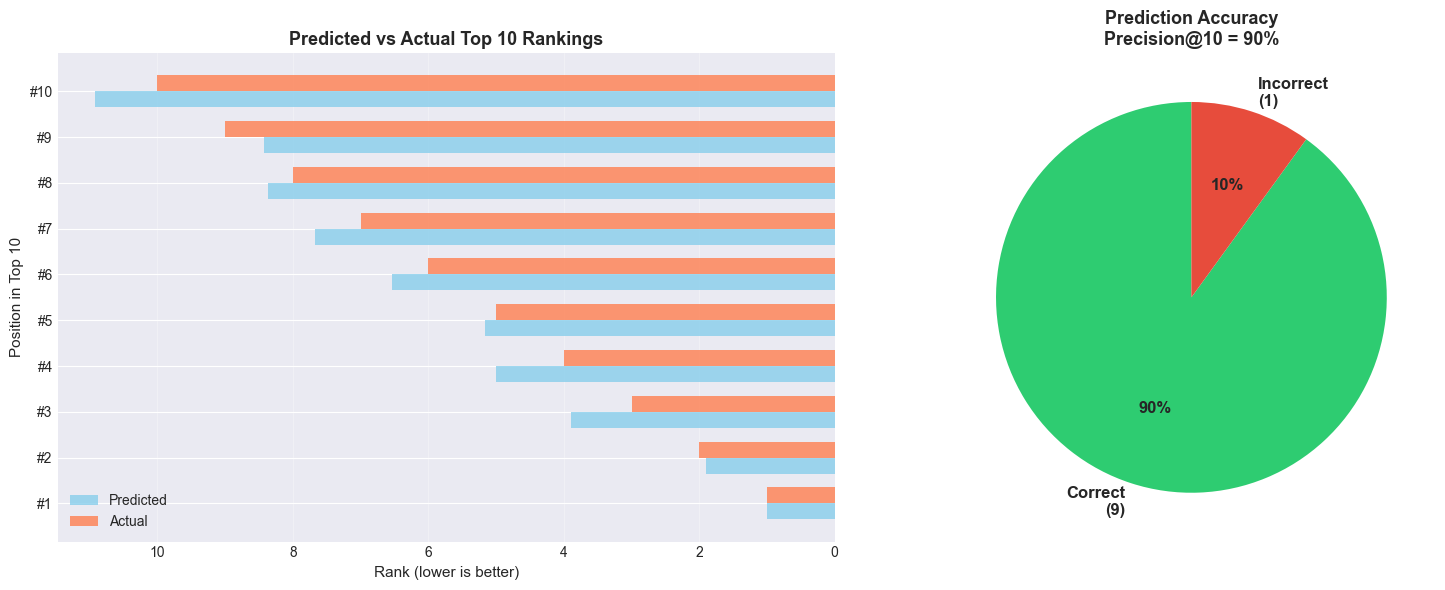

In [16]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Predicted vs Actual Top 10 (side by side)
ax1 = axes[0]
x = np.arange(10)
width = 0.35

# Predicted Top 10
predicted_ranks = predicted_df['predicted_rank'].values
ax1.barh(x - width/2, predicted_ranks, width, label='Predicted', alpha=0.8, color='skyblue')

# Actual Top 10
actual_ranks = actual_top10['actual_rank'].values
ax1.barh(x + width/2, actual_ranks, width, label='Actual', alpha=0.8, color='coral')

ax1.set_xlabel('Rank (lower is better)', fontsize=11)
ax1.set_ylabel('Position in Top 10', fontsize=11)
ax1.set_title('Predicted vs Actual Top 10 Rankings', fontsize=13, fontweight='bold')
ax1.set_yticks(x)
ax1.set_yticklabels([f"#{i+1}" for i in range(10)])
ax1.legend()
ax1.invert_xaxis()  # Lower ranks on the right
ax1.grid(axis='x', alpha=0.3)

# Right plot: Correct vs Incorrect predictions
ax2 = axes[1]
correct_count = comparison_df['correct'].sum()
incorrect_count = 10 - correct_count

colors_pie = ['#2ecc71', '#e74c3c']  # Green for correct, red for incorrect
ax2.pie(
    [correct_count, incorrect_count],
    labels=[f'Correct\n({correct_count})', f'Incorrect\n({incorrect_count})'],
    autopct='%1.0f%%',
    startangle=90,
    colors=colors_pie,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
ax2.set_title(f'Prediction Accuracy\nPrecision@10 = {precision_at_10:.0%}', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

---
## Section 5: Wrap-up

### What We Learned

1. **Foundation models** like Moirai2 can forecast time series with minimal setup
2. **Time series forecasting** requires careful handling of temporal order (no data leakage!)
3. **Music charts** are inherently noisy and hard to predict (viral trends, new releases)
4. **Multiple metrics** are needed to evaluate ranking predictions
5. **GluonTS format** provides a standardized way to work with time series data

### Model Performance Summary:

- Pre-trained model works out-of-the-box (no training needed)
- Captures temporal dependencies in song rankings
- Better than random baseline

In [17]:
# Summary statistics for the workshop
print("="*60)
print("WORKSHOP SUMMARY")
print("="*60)
print(f"Dataset: Spotify Viral 50 Italy ({df['date'].min()} to {df['date'].max()})")
print(f"Model: Salesforce Moirai2 (foundation model)")
print(f"Task: Predict Top 10 songs for {analysis_date.strftime('%Y-%m-%d')}")
print()
print("RESULTS:")
print(f"  • Precision@10: {precision_at_10:.1%}")
print(f"  • Recall@10:    {recall_at_10:.1%}")
print(f"  • F1@10:        {f1_at_10:.1%}")
print(f"  • RMSE:         {rmse:.2f} ranks")
print(f"  • Correct:      {correct_predictions}/10 songs")
print()
print("KEY TAKEAWAY:")
print("Foundation models like Moirai2 provide a strong baseline for")
print("time series forecasting without extensive feature engineering!")
print("="*60)

WORKSHOP SUMMARY
Dataset: Spotify Viral 50 Italy (2017-01-01 00:00:00 to 2021-12-31 00:00:00)
Model: Salesforce Moirai2 (foundation model)
Task: Predict Top 10 songs for 2021-12-31

RESULTS:
  • Precision@10: 90.0%
  • Recall@10:    90.0%
  • F1@10:        90.0%
  • RMSE:         5.50 ranks
  • Correct:      9/10 songs

KEY TAKEAWAY:
Foundation models like Moirai2 provide a strong baseline for
time series forecasting without extensive feature engineering!
